## Imports

In [1]:
import pandas as pd
import numpy as np
import sys
import matplotlib.pyplot as plt
import os
import seaborn as sns
from sklearn import metrics
from sklearn.metrics import accuracy_score
from scipy.interpolate import UnivariateSpline
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.model_selection import GroupShuffleSplit
from imblearn.under_sampling import RandomUnderSampler, NearMiss
from imblearn.over_sampling import RandomOverSampler, SMOTE
from sklearn.model_selection import train_test_split
from aeon.distances import dtw_distance, euclidean_distance
from aeon.classification.distance_based import KNeighborsTimeSeriesClassifier
from aeon.transformations.collection import PaddingTransformer
from aeon.classification.feature_based import Catch22Classifier
from aeon.testing.data_generation import make_example_3d_numpy
from aeon.classification.deep_learning import TimeCNNClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay

/usr/lib/python3.12/site-packages/aeon/base/__init__.py:24: FutureWarning: The aeon package will soon be releasing v1.0.0 with the removal of legacy modules and interfaces such as BaseTransformer and BaseForecaster. This will contain breaking changes. See aeon-toolkit.org for more information. Set aeon.AEON_DEPRECATION_WARNING or the AEON_DEPRECATION_WARNING environmental variable to 'False' to disable this warning.
  warnings.warn(
2024-11-04 17:40:31.686012: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE3 SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Carga da base

In [2]:
df_total = pd.DataFrame()
id_pessoa = 0
for i in os.listdir('normalizacao/'):
    df = pd.read_excel(f"normalizacao/{i}",header=None)
    df['Nome'] = id_pessoa
    id_pessoa += 1
    df_total = pd.concat([df,df_total])
df_total = df_total.rename(columns={1:'Qtd Total Pontos',2:'Qtd Dados'})

In [3]:
df_total['Fadiga'] = [0 if x == 'Normal' else 1 for x in df_total[0]]
df_total

,0,Qtd Total Pontos,Qtd Dados,3,4,5,6,7,8,9,...,6998,6999,7000,7001,7002,7003,7004,7005,7006,Fadiga
0,Normal,250,249,617.690186,617.679871,617.748291,617.704529,617.624207,617.557251,617.412354,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
1,Normal,206,206,905.522034,905.256958,905.053467,904.930481,904.830872,904.792175,904.865112,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
2,Erro na Coleta,1290,689,599.337158,603.076416,606.548157,609.216492,610.949463,611.528442,611.240906,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
3,Erro na Coleta,120,99,750.602417,749.031067,747.358887,745.603943,743.997986,742.309265,740.471191,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
4,Erro na Coleta,277,92,624.175659,624.377319,624.488586,624.601196,624.832397,625.039429,625.369690,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
166,Normal,177,175,585.330566,585.392761,585.384583,585.461975,585.557800,585.493591,585.342041,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
167,Normal,226,225,869.773010,869.624756,869.500549,869.216614,869.062622,868.875000,868.664856,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
168,Normal,212,212,586.307861,586.316895,586.388367,586.399536,586.374939,586.223206,586.212463,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
169,Normal,200,200,862.808289,863.046753,863.196655,863.211609,863.170715,863.205017,863.242798,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0


## Pipeline de Tratamentos

In [4]:
nomes = df_total['Nome'].to_numpy()
X = df_total.drop([0,'Fadiga','Qtd Dados','Nome'], axis=1)
gss = GroupShuffleSplit(n_splits = 5, train_size = 12, test_size = 5)

train = gss.split(X=X, groups=nomes)
print(train)
# for i, (train_index, test_index) in enumerate(gss.split(X=X, groups=nomes)):
#     print(i)
#     print(np.unique(nomes[train_index]))
#     print(np.unique(nomes[test_index]))

<generator object BaseShuffleSplit.split at 0x7288ee2a7c40>


In [5]:
def pipeline_knn(df_total, seed, n_splits = 5, sampler = 'Under'):
    #Separar em Treino e Teste
    #12 treino 5 teste
    X = df_total.drop([0,'Fadiga','Qtd Dados','%De N Vazios','Nome'], axis=1)
    y = df_total['Fadiga']
    group = df_total['Nome'].to_numpy()

    gss = GroupShuffleSplit(n_splits = n_splits, train_size = 12, test_size = 5, random_state = seed)

    lista_data_train= []
    lista_labels_train = []
    lista_data_test = []
    lista_labels_test = []
    for i, (train_index, test_index) in enumerate(gss.split(X=X, groups=group)):
        print(f'Fold {i}')
        print(f'Pessoas Treino: {np.unique(group[train_index])}')
        print(f'Pessoas Teste: {np.unique(group[test_index])}')

        train_data = X.loc[train_index]
        train_labels = y.loc[train_index]
        test_data = X.loc[test_index]
        test_labels = y.loc[test_index]

    
        print(f'Quantidade Treino: {len(train_data)}')
        print(f'Quantidade Teste: {len(test_data)}')

        #Balanceamento de Dados
        train_data.columns = train_data.columns.astype(str)
        print(train_labels.value_counts())
        if sampler == 'Under':
            rs = RandomUnderSampler(random_state = seed)
        elif sampler == 'Over':
            rs = RandomOverSampler(random_state = seed)
        train_data_re, train_labels_re = rs.fit_resample(train_data, train_labels)
        #train_data_re, train_labels_re = train_data, train_labels
    
        print(train_labels_re.value_counts())

        #Interpolacao dos Segmentos
        segmentos_treino = []
        train_qtd = train_data_re['Qtd Total Pontos'].values
        count = 0
        for linha in train_data_re.drop(['Qtd Total Pontos'],axis=1).values:
            serie = linha[:train_qtd[count]]
            serie = pd.Series(serie).interpolate().to_numpy()
            if pd.isna(serie[0]):
                serie = serie[1:]
            segmentos_treino.append(serie)
            count += 1
        segmentos_test = []
        test_qtd = test_data['Qtd Total Pontos'].values
        count = 0
        for linha in test_data.drop(['Qtd Total Pontos'],axis=1).values:
            serie = linha[:test_qtd[count]]
            serie = pd.Series(serie).interpolate().to_numpy()
            if pd.isna(serie[0]):
                serie = serie[1:]
            segmentos_test.append(serie)
            count += 1

        #Colocando no Shape necessario
        train_data_x = []
        for i in segmentos_treino:
            train_data_x.append(np.array(i).reshape(1,len(i)))
        test_data_x = []
        for i in segmentos_test:
            test_data_x.append(np.array(i).reshape(1,len(i)))
        train_labels_y = np.array(train_labels_re.values)
        test_labels_y = np.array(test_labels.values)

        #Coloca na lista de Splits
        lista_data_train.append(train_data_x)
        lista_labels_train.append(train_labels_y)
        lista_data_test.append(test_data_x)
        lista_labels_test.append(test_labels_y)

    
    return lista_data_train, lista_labels_train, lista_data_test, lista_labels_test

In [6]:
def test_uma_pessoa (df):
    segmentos = []
    train_qtd = df['Qtd Total Pontos'].values
    count = 0
    for linha in df.drop([0,'Fadiga','Nome','Qtd Dados','Qtd Total Pontos','%De N Vazios'],axis=1).values:
        serie = linha[:train_qtd[count]]
        serie = pd.Series(serie).interpolate().to_numpy()
        if pd.isna(serie[0]):
            serie = serie[1:]
        segmentos.append(serie)
        count += 1
    labels = df['Fadiga']
    return segmentos, labels.values

Filtro Baseado na Analise

In [7]:
df_total['%De N Vazios'] = df_total['Qtd Dados'] / df_total['Qtd Total Pontos']
df_filtrado = df_total[(df_total['%De N Vazios'] > 0.85) 
    & (df_total[0] != 'Erro na Coleta') 
    & ((df_total['Qtd Total Pontos'] < 500) | (df_total[0] == 'Platô'))  
    & (df_total['Qtd Total Pontos'] < 1000)
    & (df_total['Nome'] != 'Josefina')
]
df_filtrado = df_filtrado.reset_index(drop=True)

## KNN com Catch 22

In [8]:
seed = 10
train_data_x, train_labels_y, test_data_x, test_labels_y = pipeline_knn(df_filtrado,seed = seed,n_splits = 10,sampler = 'Under')

Fold 0
Pessoas Treino: [ 0  1  2  4  8 10 11 12 13 14 15 17]
Pessoas Teste: [ 3  5  6  7 16]
Quantidade Treino: 5845
Quantidade Teste: 1652
Fadiga
0    4992
1     853
Name: count, dtype: int64
Fadiga
0    853
1    853
Name: count, dtype: int64
Fold 1
Pessoas Treino: [ 1  4  6  8  9 10 11 12 13 14 15 17]
Pessoas Teste: [0 2 3 5 7]
Quantidade Treino: 5926
Quantidade Teste: 2338
Fadiga
0    5106
1     820
Name: count, dtype: int64
Fadiga
0    820
1    820
Name: count, dtype: int64
Fold 2
Pessoas Treino: [ 0  1  2  4  5  6  7  9 12 15 16 17]
Pessoas Teste: [ 3  8 10 11 14]
Quantidade Treino: 4933
Quantidade Teste: 3050
Fadiga
0    4209
1     724
Name: count, dtype: int64
Fadiga
0    724
1    724
Name: count, dtype: int64
Fold 3
Pessoas Treino: [ 0  1  2  4  6  7  8 10 12 14 15 16]
Pessoas Teste: [ 3  5 11 13 17]
Quantidade Treino: 5775
Quantidade Teste: 1722
Fadiga
0    4940
1     835
Name: count, dtype: int64
Fadiga
0    835
1    835
Name: count, dtype: int64
Fold 4
Pessoas Treino: [ 0  2

In [9]:
acuracias_knn = []
f1_score_knn = []
for X_train, y_train, X_test, y_test in zip(train_data_x, train_labels_y, test_data_x, test_labels_y):
    clf = Catch22Classifier(
        estimator = KNeighborsTimeSeriesClassifier(distance=dtw_distance, n_neighbors = 5), 
        replace_nans=True,
        outlier_norm=True,
        random_state=0,
    )
    clf.fit(X_train, y_train)
    predicts = clf.predict(X_test)
    acuracias_knn.append(metrics.accuracy_score(y_test, predicts))
    f1_score_knn.append(metrics.f1_score(y_test, predicts, average='weighted'))

In [10]:
print(acuracias_knn)
print(f1_score_knn)
melhor_fold = np.argmax(f1_score_knn)
print(melhor_fold)

[0.587772397094431, 0.6154833190761334, 0.5229508196721312, 0.7131242740998839, 0.5886402753872634, 0.6491885143570537, 0.48111332007952284, 0.4841237113402062, 0.7317073170731707, 0.7523204689789936]
[0.6446676618217875, 0.6719057361331532, 0.6022091473796474, 0.7289734172785776, 0.6980628902745848, 0.72067705917576, 0.5065778033198075, 0.5609444715263083, 0.7961105151842154, 0.7923110575941935]
8


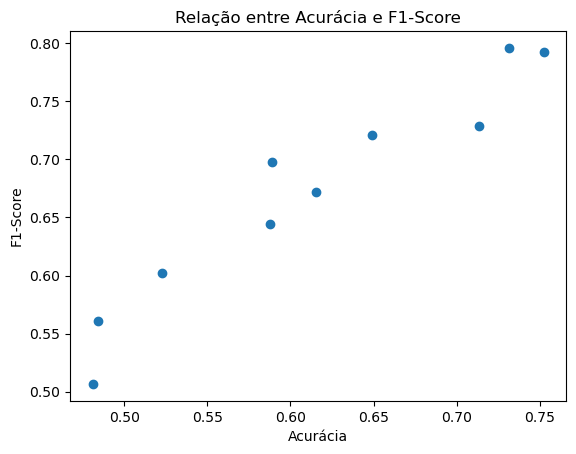

In [11]:
fig, ax = plt.subplots()

ax.scatter(acuracias_knn, f1_score_knn)
ax.set_xlabel('Acurácia')
ax.set_ylabel('F1-Score')
plt.title('Relação entre Acurácia e F1-Score')
plt.show()

### Visualizar o melhor resultado

In [12]:
X_train, y_train, X_test, y_test = train_data_x[melhor_fold], train_labels_y[melhor_fold], test_data_x[melhor_fold], test_labels_y[melhor_fold]
clf = Catch22Classifier(
    estimator = KNeighborsTimeSeriesClassifier(distance=dtw_distance, n_neighbors = 5), 
    replace_nans=True,
    outlier_norm=True,
    random_state=0,
)
clf.fit(X_train, y_train)

Catch22Classifier(estimator=KNeighborsTimeSeriesClassifier(distance=CPUDispatcher(<function dtw_distance at 0x7289443b4a40>),
                                                           n_neighbors=5),
                  outlier_norm=True, random_state=0)

In [13]:
predicts = clf.predict(X_test)

acc = accuracy_score(y_test,predicts)
print(acc)

0.7317073170731707


In [14]:
print(classification_report(y_test,predicts))

              precision    recall  f1-score   support

           0       0.94      0.76      0.84      2689
           1       0.07      0.28      0.12       181

    accuracy                           0.73      2870
   macro avg       0.51      0.52      0.48      2870
weighted avg       0.89      0.73      0.80      2870



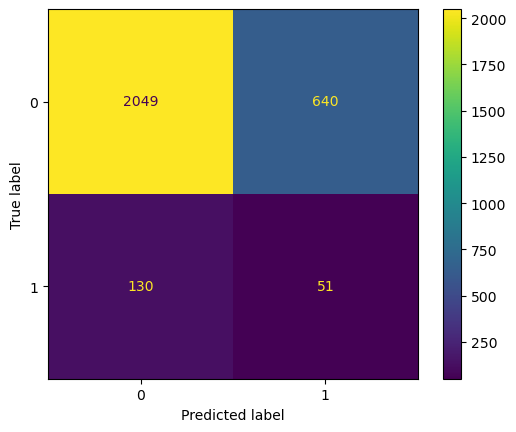

In [15]:
disp = ConfusionMatrixDisplay.from_predictions(y_test,predicts)

### Classificação de 1 pessoa

In [18]:
pessoa, labels = test_uma_pessoa(df_filtrado[df_filtrado['Nome'] == 7])
pessoa_x = []
for i in pessoa:
    pessoa_x.append(np.array(i).reshape(1,len(i)))
labels_y = np.array(labels)

In [19]:
predicts = clf.predict(pessoa_x)

acc = accuracy_score(labels_y,predicts)
print(acc)

0.597457627118644


In [20]:
print(classification_report(labels_y,predicts))

              precision    recall  f1-score   support

           0       0.99      0.60      0.75       235
           1       0.00      0.00      0.00         1

    accuracy                           0.60       236
   macro avg       0.50      0.30      0.37       236
weighted avg       0.99      0.60      0.74       236



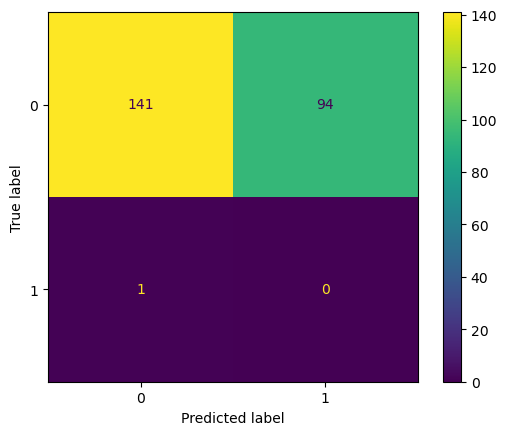

In [21]:
disp = ConfusionMatrixDisplay.from_predictions(labels_y,predicts)

In [22]:
y = 0
count = 0
column_y = []
column_x = []
label = []
for serie in pessoa_x:
    for line in serie:
        for x in line:
            if labels_y[count] == 1 and predicts[count] == 1:
                column_y.append(y)
                column_x.append(x)
                label.append('TP')
                column_y.append(y)
                column_x.append(np.nan)
                label.append('TN')
                column_y.append(y)
                column_x.append(np.nan)
                label.append('FP')
                column_y.append(y)
                column_x.append(np.nan)
                label.append('FN')
            if labels_y[count] == 0 and predicts[count] == 0:
                column_y.append(y)
                column_x.append(np.nan)
                label.append('TP')
                column_y.append(y)
                column_x.append(x)
                label.append('TN')
                column_y.append(y)
                column_x.append(np.nan)
                label.append('FP')
                column_y.append(y)
                column_x.append(np.nan)
                label.append('FN')
            if labels_y[count] == 0 and predicts[count] == 1:
                column_y.append(y)
                column_x.append(np.nan)
                label.append('TP')
                column_y.append(y)
                column_x.append(np.nan)
                label.append('TN')
                column_y.append(y)
                column_x.append(x)
                label.append('FP')
                column_y.append(y)
                column_x.append(np.nan)
                label.append('FN')
            if labels_y[count] == 1 and predicts[count] == 0:
                column_y.append(y)
                column_x.append(np.nan)
                label.append('TP')
                column_y.append(y)
                column_x.append(np.nan)
                label.append('TN')
                column_y.append(y)
                column_x.append(np.nan)
                label.append('FP')
                column_y.append(y)
                column_x.append(x)
                label.append('FN')

            y += 1
        count += 1 
teste_df = pd.DataFrame({'x':column_x,'y':column_y,'label':label})


In [23]:
teste_df.to_excel("resultados/7.xlsx", index=False)

In [24]:
X_train, y_train, X_test, y_test = train_data_x[melhor_fold], train_labels_y[melhor_fold], test_data_x[melhor_fold], test_labels_y[melhor_fold]

In [ ]:
melhor_acc_knn = 0.0
melhor_parm_k = 0
melhor_parm_knn = [0,'']
distances = ['euclidean','squared','manhattan','minkowski','dtw']
for dist in distances:
    for k in range(1,25):
        clf = Catch22Classifier(
        estimator = KNeighborsTimeSeriesClassifier(distance=dist, n_neighbors = k), #RandomForestClassifier(n_estimators=100),
            replace_nans=True,
            outlier_norm=True,
            random_state=0,
        )
        clf.fit(X_train, y_train)
        predicts = clf.predict(X_test)
        acc = accuracy_score(y_test,predicts)
        print(f'Distance: {dist}, k: {k} Acuracy:{acc}')
        if(melhor_acc_knn < acc):
            melhor_acc = acc
            melhor_parm_knn[0] = k
            melhor_parm_knn[1] = dist

In [ ]:
print(melhor_acc_knn)
print(melhor_parm_knn)

In [ ]:
clf = Catch22Classifier(
estimator = KNeighborsTimeSeriesClassifier(distance=melhor_parm_knn[1], n_neighbors = melhor_parm_knn[0]), #RandomForestClassifier(n_estimators=100),
    replace_nans=True,
    outlier_norm=True,
    random_state=0,
)
clf.fit(X_train, y_train)
predicts = clf.predict(X_test)
acc = accuracy_score(y_test,predicts)

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test,predicts))

In [ ]:
disp = ConfusionMatrixDisplay.from_predictions(y_test,predicts)

In [ ]:
pessoa, labels = test_uma_pessoa(df_filtrado[df_filtrado['Nome'] == 'Teresinha'])
pessoa_x = []
for i in pessoa:
    pessoa_x.append(np.array(i).reshape(1,len(i)))
labels_y = np.array(labels)

In [ ]:
predicts = clf.predict(pessoa_x)

acc = accuracy_score(labels_y,predicts)
print(acc)

In [ ]:
print(classification_report(labels_y,predicts))

In [ ]:
disp = ConfusionMatrixDisplay.from_predictions(labels_y,predicts)

In [ ]:
y = 0
count = 0
column_y = []
column_x = []
label = []
for serie in pessoa_x:
    for line in serie:
        for x in line:
            if labels_y[count] == 1 and predicts[count] == 1:
                column_y.append(y)
                column_x.append(x)
                label.append('TP')
                column_y.append(y)
                column_x.append(np.nan)
                label.append('TN')
                column_y.append(y)
                column_x.append(np.nan)
                label.append('FP')
                column_y.append(y)
                column_x.append(np.nan)
                label.append('FN')
            if labels_y[count] == 0 and predicts[count] == 0:
                column_y.append(y)
                column_x.append(np.nan)
                label.append('TP')
                column_y.append(y)
                column_x.append(x)
                label.append('TN')
                column_y.append(y)
                column_x.append(np.nan)
                label.append('FP')
                column_y.append(y)
                column_x.append(np.nan)
                label.append('FN')
            if labels_y[count] == 0 and predicts[count] == 1:
                column_y.append(y)
                column_x.append(np.nan)
                label.append('TP')
                column_y.append(y)
                column_x.append(np.nan)
                label.append('TN')
                column_y.append(y)
                column_x.append(x)
                label.append('FP')
                column_y.append(y)
                column_x.append(np.nan)
                label.append('FN')
            if labels_y[count] == 1 and predicts[count] == 0:
                column_y.append(y)
                column_x.append(np.nan)
                label.append('TP')
                column_y.append(y)
                column_x.append(np.nan)
                label.append('TN')
                column_y.append(y)
                column_x.append(np.nan)
                label.append('FP')
                column_y.append(y)
                column_x.append(x)
                label.append('FN')

            y += 1
        count += 1 
teste_df = pd.DataFrame({'x':column_x,'y':column_y,'label':label})

In [ ]:
teste_df.to_excel("resultados\Teresinha_knn.xlsx", index=False)

In [ ]:
X_train, y_train, X_test, y_test = train_data_x[melhor_fold], train_labels_y[melhor_fold], test_data_x[melhor_fold], test_labels_y[melhor_fold]

In [ ]:
melhor_acc_tree = 0.0
melhor_parm_tree = 0
for tree in range(1,200):
    clf = Catch22Classifier(
    estimator = RandomForestClassifier(n_estimators = tree), #RandomForestClassifier(n_estimators=100),
        replace_nans=True,
        outlier_norm=True,
        random_state=0,
    )
    clf.fit(X_train, y_train)
    predicts = clf.predict(X_test)
    acc = accuracy_score(y_test,predicts)
    print(f'Trees:{tree} Acuracy:{acc}')
    if(melhor_acc_tree < acc):
        melhor_acc_tree = acc
        melhor_parm_tree = tree
        

In [ ]:
print(melhor_acc_tree)
print(melhor_parm_tree)

In [ ]:
clf = Catch22Classifier(
estimator = RandomForestClassifier(n_estimators = melhor_parm_tree), #RandomForestClassifier(n_estimators=100),
    replace_nans=True,
    outlier_norm=True,
    random_state=0,
)
clf.fit(X_train, y_train)
predicts = clf.predict(X_test)
acc = accuracy_score(y_test,predicts)

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test,predicts))

In [ ]:
disp = ConfusionMatrixDisplay.from_predictions(y_test,predicts)

### Uma Pessoa Random Forest

In [ ]:
pessoa, labels = test_uma_pessoa(df_filtrado[df_filtrado['Nome'] == 'Teresinha'])
pessoa_x = []
for i in pessoa:
    pessoa_x.append(np.array(i).reshape(1,len(i)))
labels_y = np.array(labels)

In [ ]:
predicts = clf.predict(pessoa_x)

acc = accuracy_score(labels_y,predicts)
print(acc)

In [ ]:
print(classification_report(labels_y,predicts))

In [ ]:
disp = ConfusionMatrixDisplay.from_predictions(labels_y,predicts)

In [ ]:
y = 0
count = 0
column_y = []
column_x = []
label = []
for serie in pessoa_x:
    for line in serie:
        for x in line:
            if labels_y[count] == 1 and predicts[count] == 1:
                column_y.append(y)
                column_x.append(x)
                label.append('TP')
                column_y.append(y)
                column_x.append(np.nan)
                label.append('TN')
                column_y.append(y)
                column_x.append(np.nan)
                label.append('FP')
                column_y.append(y)
                column_x.append(np.nan)
                label.append('FN')
            if labels_y[count] == 0 and predicts[count] == 0:
                column_y.append(y)
                column_x.append(np.nan)
                label.append('TP')
                column_y.append(y)
                column_x.append(x)
                label.append('TN')
                column_y.append(y)
                column_x.append(np.nan)
                label.append('FP')
                column_y.append(y)
                column_x.append(np.nan)
                label.append('FN')
            if labels_y[count] == 0 and predicts[count] == 1:
                column_y.append(y)
                column_x.append(np.nan)
                label.append('TP')
                column_y.append(y)
                column_x.append(np.nan)
                label.append('TN')
                column_y.append(y)
                column_x.append(x)
                label.append('FP')
                column_y.append(y)
                column_x.append(np.nan)
                label.append('FN')
            if labels_y[count] == 1 and predicts[count] == 0:
                column_y.append(y)
                column_x.append(np.nan)
                label.append('TP')
                column_y.append(y)
                column_x.append(np.nan)
                label.append('TN')
                column_y.append(y)
                column_x.append(np.nan)
                label.append('FP')
                column_y.append(y)
                column_x.append(x)
                label.append('FN')

            y += 1
        count += 1 
teste_df = pd.DataFrame({'x':column_x,'y':column_y,'label':label})

In [ ]:
teste_df.to_excel("resultados\Teresinha_rf.xlsx", index=False)